# Synthetic experiment
This notebook reproduces the *synthetic experiments* described in Section 5 of the paper titled "On the convergence of ADAM and beyond" (Reddi, Kale and Kumar 2018).

## Imports

The following modules are used:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Optimizer

We start by implementing the Adam optimizer.

In [2]:
class Adam:

    def __init__(self, x0, amsgrad=False, alpha=0.001, beta1=0.9, beta2=0.999,
                 F=None, epsilon=1e-8, decay=False):
        self.x = x0

        self.amsgrad = amsgrad
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.F = F
        self.epsilon = epsilon
        self.decay = decay

        self.m = 0
        self.v = 0
        self.t = 0
        self.vmax = 0

    def step(self, grad):
        self.t = self.t + 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * grad**2

        if self.amsgrad:
            self.vmax = max(self.vmax, self.v)
            m = self.m
            v = self.vmax
        else:
            m = self.m / (1 - self.beta1**self.t)
            v = self.v / (1 - self.beta2**self.t)

        lr = self.alpha / np.sqrt(self.t) if self.decay else self.alpha
        x_updated = self.x - lr * m / (np.sqrt(v) + self.epsilon)

        self.x = x_updated if self.F is None else np.clip(x_updated, self.F[0], self.F[1])
        return self.x


## Experiment

### Code

The below code will serve as the framework for our future experiments.

In [3]:
def experiment(modulo=101, iterations = 7000000, F=(-1,1), max_grad=1010, min_grad=-10,
               regret_graph=True, online_graph=True, stochastic_graph=True,
               online_params=(0.01, False), stochastic_params=(0.5, True)):
    
    adam_o = Adam(0, F=F, alpha=online_params[0], decay=online_params[1])
    amsg_o = Adam(0, amsgrad=True, F=F, alpha=online_params[0], decay=online_params[1])
    adam_s = Adam(1, F=F, alpha=stochastic_params[0], decay=stochastic_params[1])
    amsg_s = Adam(1, amsgrad=True, F=F, alpha=stochastic_params[0], decay=stochastic_params[1])

    iterations = range(1, iterations + 1)
    xs_adam_o, xs_amsg_o = [], []
    xs_adam_s, xs_amsg_s = [], []
    regrets_adam, regrets_amsg = [], []
    regret_adam, regret_amsg = 0, 0

    for t in iterations:    
        # Gradients
        grad_o = (max_grad if t % modulo == 1 else min_grad)
        grad_s = (max_grad if np.random.random() < 0.01 else min_grad)

        # Update the xs
        x_adam_o = adam_o.step(grad_o)
        x_amsg_o = amsg_o.step(grad_o)
        x_adam_s = adam_s.step(grad_s)
        x_amsg_s = amsg_s.step(grad_s)

        xs_adam_o.append(x_adam_o)
        xs_amsg_o.append(x_amsg_o)
        xs_adam_s.append(x_adam_s)
        xs_amsg_s.append(x_amsg_s)

        # Losses
        min_loss = min(F[0] * grad_o, F[1] * grad_o)
        adam_loss = grad_o * x_adam_o
        amsg_loss = grad_o * x_amsg_o
        regret_adam += adam_loss - min_loss
        regret_amsg += amsg_loss - min_loss
        
#         print(x_amsg_o)
#         print(grad_o * x_amsg_o)
#         print(grad_o * x_amsg_o - min_loss)
#         print()

        regrets_adam.append(regret_adam / t)
        regrets_amsg.append(regret_amsg / t)

    if regret_graph:
        regrets_adam = np.clip(regrets_adam, 0, 20.4)
        regrets_amsg = np.clip(regrets_adam, 0, 20.4)
        plt.title('Average regret per iteration (online setting)')
        plt.xlabel('iterations')
        plt.ylabel('Rt/t')
        plt.plot(iterations, regrets_adam, label='ADAM')
        plt.plot(iterations, regrets_amsg, label='AMSgrad')
        plt.legend()
        plt.show()

    if online_graph:
        plt.title('Value of x at each iteration (online setting)')
        plt.xlabel('iterations')
        plt.ylabel('xt')
        plt.plot(iterations, xs_adam_o, label='ADAM')
        plt.plot(iterations, xs_amsg_o, label='AMSgrad')
        plt.legend()
        plt.show()

    if stochastic_graph:
        plt.title('Value of x at each iteration (stochastic setting)')
        plt.xlabel('iterations')
        plt.ylabel('xt')
        plt.plot(iterations, xs_adam_s, label='ADAM')
        plt.plot(iterations, xs_amsg_s, label='AMSgrad')
        plt.legend()
        plt.show()


### Reproducing the experiment

In the following figure, we simply reproduce the results described in the paper in Figure 1. To this effect, we use the same parameters as described in the paper.

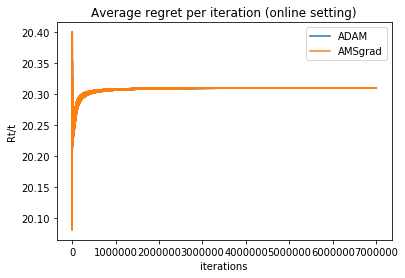

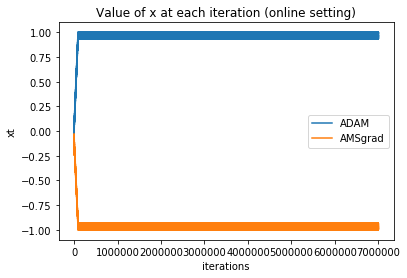

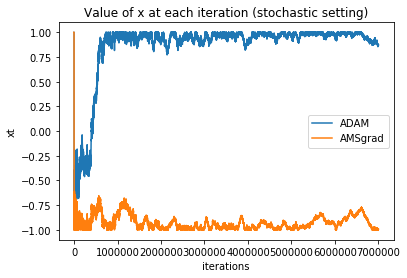

In [4]:
experiment(modulo=101)

### Modifying the modulo parameter

We start with a very low modulo (11). In this case, the optimizers receive the large gradient very often, and thus they both find the optimal solution.

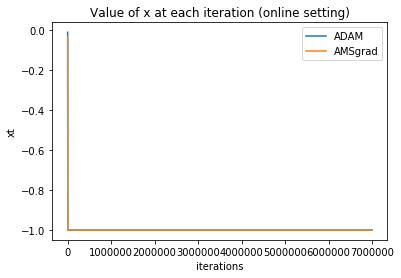

In [5]:
experiment(modulo=11, regret_graph=False, stochastic_graph=False)

We then try a very large modulo. The occurence of the large gradient become less frequent, which explains why both optimizers are unable to find the optimal solution.

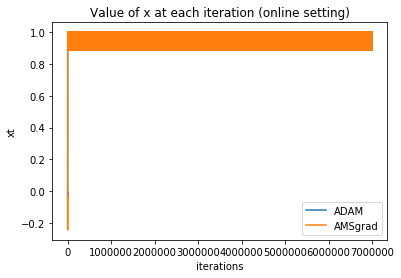

In [6]:
experiment(modulo=301, regret_graph=False, stochastic_graph=False)

The two following figures show how sensible the modulo parameter is. Indeed, one can observe that increasing or decreasing it by one dramatically changes the behaviour of the optimizers.

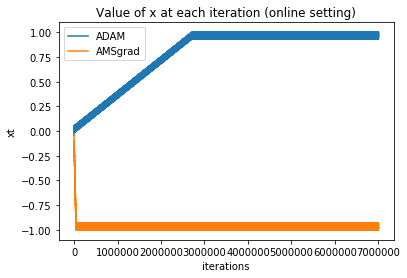

In [7]:
experiment(modulo=100, regret_graph=False, stochastic_graph=False)

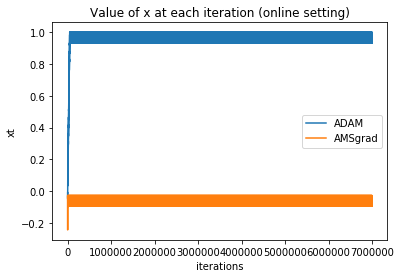

In [8]:
experiment(modulo=102, regret_graph=False, stochastic_graph=False)

### Initial learning rate

Changing the learning rate does not seem to affect the convergence of the optimizers. The only change is the oscillations during the first iterations, which are more important as the initial learning rate is large.

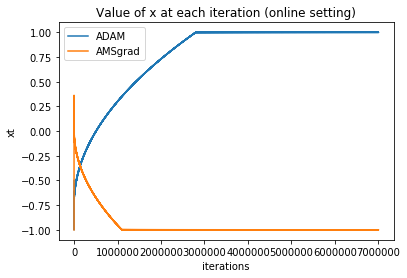

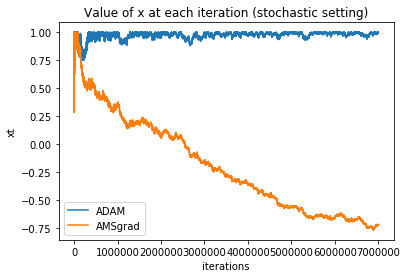

In [9]:
experiment(modulo=101, regret_graph=False, online_params=(0.5, True), stochastic_params=(0.25, True))

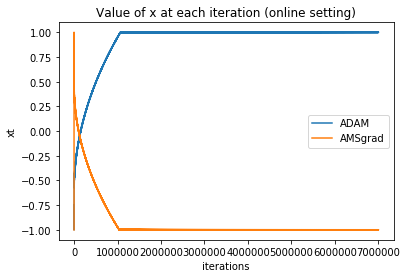

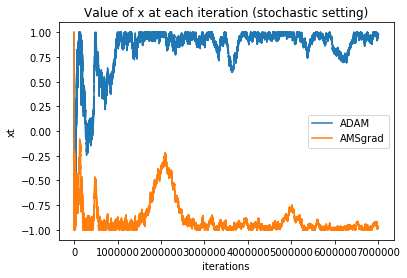

In [10]:
experiment(modulo=101, regret_graph=False, online_params=(0.75, True), stochastic_params=(0.75, True))